# 年別

In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def ranking(team):
    first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
    second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
    third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
    fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
    fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']
    lst = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
    for i in range(len(lst)):
        teams = lst[i]
        if team in teams:
            return i + 1

In [4]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [5]:
team = "Rソックス"
"""df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
lst = make_flattened_list(triple)"""

'df = event_df[event_df.攻撃チーム==team]\ntriple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))\nlst = make_flattened_list(triple)'

In [ ]:
def triple_on_score_diff(team, diff_lower, diff_upper, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif int(year) == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif int(year) == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
    lst = make_flattened_list(triple)
    res = []
    for elem in lst:
        my_score = int(elem[1][1])
        opp_score = int(elem[1][2])
        if diff_lower < diff_upper:
            if diff_lower <= my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        elif diff_lower > diff_upper:
            if diff_lower <= my_score - opp_score or my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        else:
            raise "diff_lower == diff_upper"
    return res

## positive inhibition = 勝ってるから気をぬく = 流れはいいのに点が取れない

## positive inhibitionを起こしがちなチームは、大差がつくとimp時の期待得点が下がる

# 点数気にしない

In [7]:
#imp_list = []
#det_list = []
res_dict1 = dict()
for team in teams_mlb:
    df = df_2018[df_2018.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict1[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ロイヤルズ 1.73434079927 0.729953972464
Rソックス 1.09110112729 0.941280892137
エンゼルス 0.896596966492 1.08914291887
オリオールズ 2.07696661958 0.93173705575
ブリュワーズ 1.52279025663 0.881431008828
インディアンス 2.02368299397 0.994264339997
ツインズ 1.3133155618 0.890298940168
ブルージェイズ 1.45210184204 1.10560090737
アスレチックス 1.69073195061 1.10704140305
パドレス 1.20917565355 0.919569431152
ナショナルズ 1.10317158033 0.84391607331
マリナーズ 1.29958230174 0.849371686149
メッツ 1.06962815205 0.831377455228
レンジャーズ 1.10834891167 0.892911844747
タイガース 1.42225116616 0.589737704438
Dバックス 1.39743756764 0.865164692325
ジャイアンツ 1.13897684718 0.546871213644
フィリーズ 1.01101222667 0.79344755982
ロッキーズ 2.50169731443 1.0068635569
マーリンズ 1.4435278721 0.698586754476
Wソックス 1.85376042444 0.905296725303
カブス 0.951145693766 0.689155582977
パイレーツ 1.47914353699 0.707592235481
レッズ 1.19529542241 0.716872673001
ドジャース 2.0677864503 1.01937427688
ブレーブス 1.31991273036 0.747567448246
アストロズ 1.98955862099 0.976127628249
レイズ 0.722742849424 0.778823553131
カージナルス 1.88933140785 0.83319

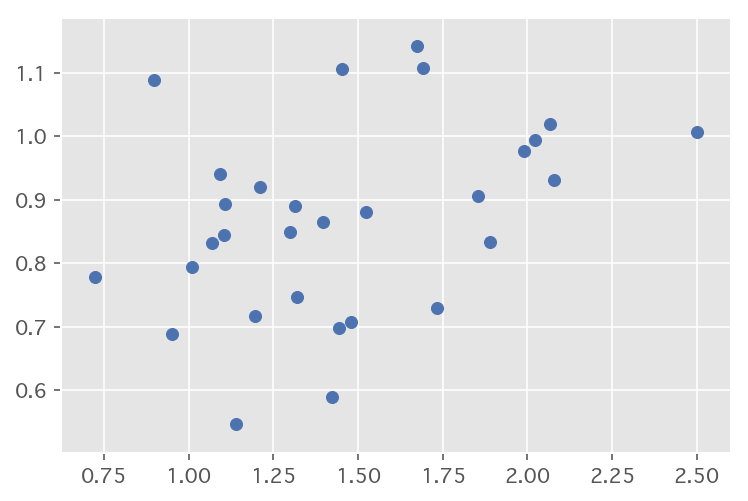

In [8]:
plt.scatter([elem[0] for elem in list(res_dict1.values())], [elem[1] for elem in list(res_dict1.values())])

# n点差以上

In [ ]:
#imp_list = []
#det_list = []
res_dict = dict()
for team in teams_mlb:
    lst = triple_on_score_diff(team, 5, 30, 2018)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ロイヤルズ 1.12394744466 0.767375824202
Rソックス 1.00796291392 0.75955151635
エンゼルス 1.18978374035 0.963294305834
オリオールズ 4.85072256403 0.78397189396
ブリュワーズ 3.55693191448 0.777699942631
インディアンス 2.47206328836 0.93891900518
ツインズ 0.606359446934 0.711324178568
ブルージェイズ 0.951861517653 1.33345170028
アスレチックス 2.81551893263 1.16914856634
パドレス 1.27131473343 0.11559070089
ナショナルズ 1.38269960096 0.740148585428
マリナーズ 0.721986390933 1.08157430837
メッツ 0.942099450444 1.766466201


In [ ]:
plt.scatter([elem[0] for elem in list(res_dict.values())], [elem[1] for elem in list(res_dict.values())])

In [ ]:
# 大差で勝っていると流れがいいとボコボコにするチーム
for team in teams_mlb:
    if res_dict1[team][0] < res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

In [ ]:
# 大差で勝っていると油断するチーム
for team in teams_mlb:
    if res_dict1[team][0] > res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])